In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# M1 Science et Ingénieurie des données
# Université de Rouen Normandie
# T. Paquet
import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import math
from numpy.linalg import norm

colors =['r','b','g','c','m','o']
n_colors = 6

#####################################################################

def logsumexp(X):
     
    X_max = max(X)
    if math.isinf(X_max):
        return -float('inf')

    acc = 0
    for i in range(X.shape[0]):
        acc += math.exp(X[i] - X_max)

    return math.log(acc) + X_max

####################################################################
#
def LogSumExp(Log_Vrais_Gauss):
    
    K,N = np.shape(Log_Vrais_Gauss)
    
    logsomme = np.zeros(N)
    for n in range(N):
        logsomme[n] = logsumexp(Log_Vrais_Gauss[:,n])
        
    return logsomme
    
####################################################################
#
#            Generation aléatoire d'un ensemble de N échantillons 
#            conforme à la loi du mélange
def my_GMM_generate(P,Mean,Cov,N,Visualisation=False):
    
    K,p = np.shape(Mean)
    effectifs=np.array(N*P ,dtype=int)
    X=np.random.multivariate_normal(Mean[0,:],Cov[0,:,:],effectifs[0])
    y=[0 for i in range(effectifs[0])]
    for k in range(1,K):
        yk=[k for i in range(effectifs[k])]
        Xk=np.random.multivariate_normal(Mean[k,:],Cov[k,:,:],effectifs[k])
        X=np.concatenate((X,Xk),axis=0)  
        y=np.concatenate((y,yk),axis=0)  
    if Visualisation: #on visualise les deux premières coordonnées 
        plt.figure(figsize=(8,8))
        debut=0
        for k in range(K):
            fin=debut+effectifs[k]
            plt.plot(X[debut:fin,0],X[debut:fin,1],colors[k]+'o',markersize=4,markeredgewidth=3)
            plt.plot(Mean[k,0],Mean[k,1],'kx',markersize=10,markeredgewidth=3)
            debut=fin
        plt.xlim(-10, 10)
        plt.ylim(-10,10)
        plt.savefig('generate.png')
        plt.show()
       
    return X, y

##############################################################
def my_G_LogVraisemblance(X,mean,cov):
    
    N,p = np.shape(X)
    
    covinv = np.linalg.inv(cov)
    det = np.linalg.det(cov)
    log_factor = np.log((2*np.pi)**(p/2) * math.sqrt(det))
    Res = X - mean
    Ex = -np.diag(Res @ covinv @ Res.T)/2
    logvrais = Ex - log_factor
    
    return logvrais

##############################################################
def my_GMM_init(X,K):
    N,p = np.shape(X)
        
    # intialisation des proba a priori
    P = np.random.random_sample(K)
    P = P / np.sum(P)
    
    # Initialisation des centroide
    # par tirage de K exemples, pour tomber dans les données     
    Index_init = np.random.choice(N, K,replace = False)
    Mean = np.zeros((K,p))
    for k in range(K):
        Mean[k,:] = X[Index_init[k],:]

    # intitialisation des matrices de covariance 
    # par affectation des données au plus proche centroide 
    # puis calcule de la matrice de covariance par cluster
    Dist=np.zeros((K,N))
    for k in range(K):
        Dist[k,:] = np.square(norm(X - Mean[k,:],axis=1))
    y = np.argmin(Dist,axis=0)
    
    Cov = np.zeros((K,p,p))
    
    for k in range(K):
        Cluster = X[y==k,:]
        Nk = np.shape(Cluster)[0]
        Res = Cluster - Mean[k,:]
        Cov[k,:,:] = Res.T @ Res / Nk
        
    return P, Mean, Cov

###########################################################################
def my_GMM_p_a_posteriori(X,K,P,Mean,Cov):
    N,p=np.shape(X)
    Log_Vrais_Gauss = np.zeros((K, N))
    for k in range(K):
        Log_Vrais_Gauss[k, :]=math.log(P[k])+my_G_LogVraisemblance(X,Mean[k,:],Cov[k,:,:])

        LogDen=LogSumExp(Log_Vrais_Gauss)
        Proba_Clusters=np.exp(Log_Vrais_Gauss-LogDen)
        LogVrais=np.sum(LogDen)

    
    return Proba_Clusters,LogVrais

###########################################################################
def my_GMM_predict(X,K,P,Mean,Cov):
    
    Proba_Clusters, LogVrais = my_GMM_p_a_posteriori(X,K,P,Mean,Cov)
    
    y = np.argmax(Proba_Clusters,axis=0)
    
    return y,LogVrais

##########################################################################
def my_GMM_fit(X,K,Visualisation=False,Seuil=0.0000001,Max_iterations = 100):
    
    N,p = np.shape(X)

    # INITIALISATION D'UN PREMIER MODÈLE
    P, Mean, Cov = my_GMM_init(X,K)

    if Visualisation :
        print("P init = ",P)
        print("Mean init = ",Mean)
        print("Cov init = ",Cov)
    
    iteration = 0    
    Log_Vrais_Gauss = np.zeros((K,N))
    Nk = np.zeros(K)
    New_Mean = np.zeros((K,p))
    New_Cov = np.zeros((K,p,p))
    New_P = np.zeros(K)

    LOGVRAIS=np.zeros(Max_iterations+1)
    LOGVRAIS[0] = -100000

    while iteration < Max_iterations:
        iteration +=1
        #################################################################
        # E step : estimation des données manquantes 
        #          affectation des données aux clusters les plus proches
        Proba_Clusters, LOGVRAIS[iteration] = my_GMM_p_a_posteriori(X,K,P,Mean,Cov)
    
        if np.abs(LOGVRAIS[iteration] - LOGVRAIS[iteration-1]) / np.abs(LOGVRAIS[iteration]) < Seuil:
            print("itération =",iteration,"BREAK")
            break
    
#         ###########################################################SyntaxError: unterminated string literal (detected at line 45)
        for k in range(K):
            Nk[k]=np.sum(Proba_Clusters[k,:])
            New_Mean[k,:]=np.sum(X.T*Proba_Clusters[k,:],axis=1)/Nk[k]

        for k in range(K):
            Res_gauche=(X-Mean[k,:]).T* Proba_Clusters[k,:]
            Res_droite=X-Mean[k,:]
            New_Cov[k,:,:]=(Res_gauche@ Res_droite)*np.identity(p)/Nk[k]
#         # les proba des clusters
        New_P=Nk/N
#       ##### compléter ici
        
        Mean = New_Mean
        P = New_P
        Cov = New_Cov
        
        
         
    if Visualisation:
        fig = plt.figure(figsize=(8, 6))
        plt.plot(LOGVRAIS[1:iteration], 'o-')
        plt.xlabel('Iteration')
        plt.ylabel('Vraisemblance')
        plt.show()
            
    return P, Mean, Cov, LOGVRAIS[1:iteration]


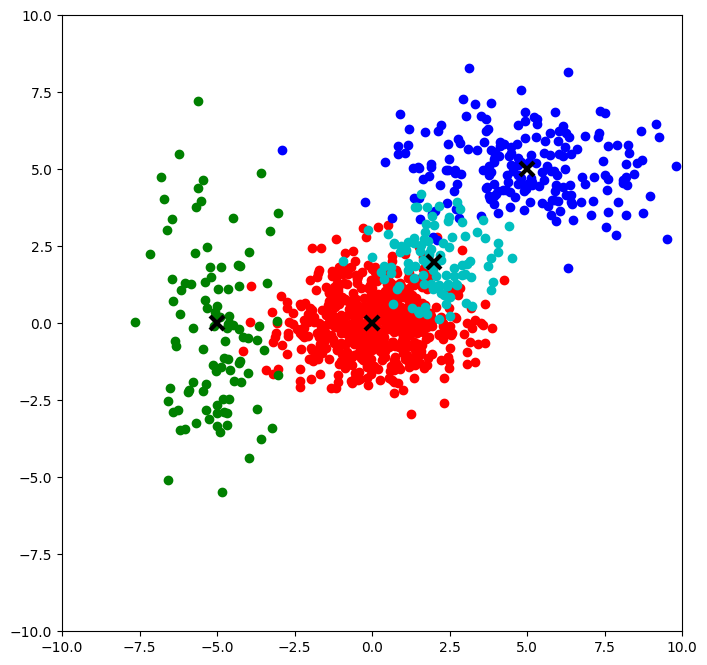

" plt.figure(figsize=(8,8))\nfor k in range(K):\n    plt.plot(X[y==k,0],X[y==k,1],colors[k]+'o',markersize=4,markeredgewidth=3)\n    plt.plot(MEAN[k,0],MEAN[k,1],'kx',markersize=10,markeredgewidth=3)\nplt.xlim(-10, 10)\nplt.ylim(-10,10)\nplt.show()"

In [16]:
    PROB = np.array([0.6,0.2,0.1,0.1])
    MEAN = np.array([[0,0],[5,5],[-5,0],[2,2]])
    COV = np.array([[[2,0],
                     [0,1]]
                    ,[[5,0],
                      [0,1]],
                    [[1,0],
                     [0,5]],
                    [[1,0],
                     [0,1]]])
    
    K,p = np.shape(MEAN)    
    N = 1000

    X,y = my_GMM_generate(PROB,MEAN,COV,N,Visualisation=True)

    #P, Mean, Cov, LOGVRAIS = my_GMM_fit(X,K,Visualisation=True)

    #y, LV = my_GMM_predict(X,K,P,Mean,Cov)
    
    """ plt.figure(figsize=(8,8))
    for k in range(K):
        plt.plot(X[y==k,0],X[y==k,1],colors[k]+'o',markersize=4,markeredgewidth=3)
        plt.plot(MEAN[k,0],MEAN[k,1],'kx',markersize=10,markeredgewidth=3)
    plt.xlim(-10, 10)
    plt.ylim(-10,10)
    plt.show()"""